In [14]:
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore


from dotenv import load_dotenv
import os
from langchain.document_loaders import JSONLoader
import numpy as np
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, as_completed # for parallelizing research
import json


In [2]:
load_dotenv(override=True)  # This will load environment variables from .env file

True

In [3]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large") ## why?
vector_store = InMemoryVectorStore(embeddings) # why?
llm = ChatOpenAI(model="gpt-4o-mini") # why?

In [4]:
loader1 = JSONLoader(
    file_path="charlesRiverAssets/how.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

loader2 = JSONLoader(
    file_path="charlesRiverAssets/whereTo.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

loader3 = JSONLoader(
    file_path="charlesRiverAssets/who.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

# Combine documents from all loaders
documents = []
for loader in [loader1, loader2, loader3]:
    documents.extend(loader.load())


In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, 
    chunk_overlap=40,
    separators=["{", "}", ",", "\n"]
    )
all_splits = text_splitter.split_documents(documents)

In [6]:
print(len(all_splits))
for doc in all_splits:
    print("===============")
    print(doc)

41
page_content='{"subPlans": [{"goal":' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}
page_content='{"description": "Improve client engagement and streamline post-project support systems for Precision Solutions by April 2024.", "deadline": "2024-04-30"' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}
page_content='}, "justification": "To enhance customer satisfaction and strengthen long-term business relationships while reflecting Charles' value of continuous improvement.", "actionItems": [' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}
page_content='{"what": "Conduct a comprehensive analysis of current client engagement practices and identify key areas for improvement.", "when": "Every Monday, 9 AM - 11 AM", "duration": "2 hours per session"},' metad

In [7]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [8]:
whoSchema = """{
    Name: string,
    DOB: string,  // ISO date format
    Gender: string,
    "Core Values": string[],
    "Personality Traits": string[],
    "Hobbies/Interests": string[]
    }"""
whereToSchema = """{
desires: Array<{
    description: string,
    strength: number,  // Scale 1-10
    timeliness: string // Time period or "Ongoing"
}>
}"""
howSchema = """{
subPlan: Array<{
    goal: {
        description: string,
        deadline: string  // ISO date format
    },
    justification: string,
    actionItems: Array<{
        what: string,
        when: string,    // Schedule description
        duration: string  // Time period
    }>
}>
}"""
whoDescription = "personal information about the user."
whereToDescription = "information about the user's most important desires."
howDescription = "information about the user's plan to obtain each of their desires from a high level."
dataSourcesAndDescriptions = [(whoSchema, whoDescription), (whereToSchema, whereToDescription), (howSchema, howDescription)]

In [26]:
user = json.load(open("./charlesRiverAssets/who.json"))["Name"]
promptFXN = lambda state: f"""You are {user}'s assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
            Question: {state['question']}
            Context: {state['context']}
            """

In [40]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    desiredInformation: List[str]

def getScore(cosineSimilarity):
    return cosineSimilarity #abs(cosineSimilarity)
# Define application steps

def research(state: State):
    prompt = f"You are a helpful assistant preparing to answer the following question: {state['question']}. Generate a short (2 - 3 item) list of information about the user that would help you to answer their question accurately. Return the list as a newline-separated string."
    response = llm.invoke(prompt)
    return {"desiredInformation": response.content.split("\n")}

def retrieve(state: State, minRelevance = 0.2, numStdDev = 2):
    def getMostRelevant(raw_results):
        scores = np.array([cosine_similarity for _, cosine_similarity in raw_results])
        mean = np.mean(scores)
        std = np.std(scores)
        if True:
            plt.hist(scores)
            plt.show()
        return [raw_results[i][0] for i in np.where(scores >= mean + (std*numStdDev))[0] if raw_results[i][1] >= minRelevance]
    
    desiredInformation = state["desiredInformation"]
    print(len(desiredInformation))
    docs = {}
    with ThreadPoolExecutor() as executor:
        future_to_info = {
            executor.submit(
                vector_store.similarity_search_with_score, info, k=len(all_splits)
            ): info for info in desiredInformation
        }
        for future in as_completed(future_to_info):
            info = future_to_info[future]
            print(f"Processing search results for: {info}")
            raw_results = future.result()
            relevant = getMostRelevant(raw_results)
            # Add relevant docs to shared dict
            for doc in relevant:
                docs[doc.id] = doc
    return {"context": list(docs.values())}

def generate(state: State):
    prompt = promptFXN(state)
    response = llm.invoke(prompt)
    print("STATE PRINT", state)
    return {"answer": response.content}

# def retrieve2(state: State, minRelevance = 0.2, stdDev = 0.5, showDistribution = True):
#     researchPromptFXN = lambda question, schema, description: f"""You are preparing to answer the following question: {question}. You are given access to a json database that contains {description} with the following schema: {schema}. Generate a list of newline-separated natural language queries that will help you answer the question. Questions should be detailed, specific, and useful."""
#     question = state["question"]
#     relevantDocs = {}
#     with ThreadPoolExecutor() as executor:
#         # Schedule all research tasks
#         future_to_desc = {
#             executor.submit(research, schema, description, question, researchPromptFXN): description
#             for schema, description in dataSourcesAndDescriptions
#         }
        
#         # Process results as they complete
#         for future in future_to_desc:
#             description = future_to_desc[future]
#             print("researching ", description)
#             for doc in future.result():
#                 relevantDocs[doc.id] = doc
#             print("===========================")
            
#     return {"context": list(relevantDocs.values())}
    

# def research(schema, description, question: str, promptFXN, numStdDev = 1, threshold = 0.2):
#     def getMostRelevant(raw_results):
#         scores = np.array([getScore(cosine_similarity) for _, cosine_similarity in raw_results])
#         mean = np.mean(scores)
#         std = np.std(scores)
#         return [raw_results[i][0] for i in np.where(scores >= mean + (std*numStdDev))[0] if raw_results[i][1] >= threshold]
    
#     prompt = promptFXN(question, schema, description)
#     response = llm.invoke(prompt)
#     print("PROMPT: ", prompt)
#     print("QUERIES: ", response.content)
#     queries = response.content.split("\n") # split into specific "queries"
#     docs = {}
#     for query in queries:
#         relevant = getMostRelevant(vector_store.similarity_search_with_score(query))
#         for doc in relevant:
#             docs[doc.id] = doc
#     return list(docs.values())

# def retrieve(state: State, minRelevance = 0.2, stdDev = 1, showDistribution = True, document = None):
#     raw_results = vector_store.similarity_search_with_score(state["question"], k = len(all_splits)) # score is cosine similarity
#     print("len raw_results", len(raw_results))
#     if len(raw_results) == 1:
#         return {"context": [raw_results[0][0]]}
#     else:
#         # I think absolute value of score measures true similarity, will test this hypothesis somehow
#         scores = np.array([getScore(cosine_similarity) for _, cosine_similarity in raw_results])
#         indicesAboveMinRelevance = np.where(scores > minRelevance)[0]
#         #meanScore = np.mean(scores)
#         #stdScore = np.std(scores)
#         if showDistribution:
#             plt.hist(scores)
#             plt.show()

#         if len(indicesAboveMinRelevance):
#             return {"context": [raw_results[i][0] for i in indicesAboveMinRelevance]} # return all documents above minRelevance
#         else:
#             #maxScoreIndex = np.argmax(scores)
#             return {"context": [raw_results[0][0]]} # return the most relevant documen

# def generate(state: State):
#     print("state['context']", state["context"])
#     docs_content = "\n\n".join(doc.page_content for doc in state["context"])
#     messages = prompt.invoke({"question": state["question"], "context": docs_content})
#     response = llm.invoke(messages)
#     return {"answer": response.content}

# def generate2(state: State):
#     prompt = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question."""
#     who, how, whereTo = [], [], []
#     for doc in state["context"]:
#         if "who" in doc.metadata["source"]:
#             who.append(doc.page_content)
#         elif "how" in doc.metadata["source"]:
#             how.append(doc.page_content)
#         elif "whereTo" in doc.metadata["source"]:
#             whereTo.append(doc.page_content)
#     if who:
#         who_content = "\n\n".join(who)
#         prompt += f"{whoDescription}: {who_content}\n."
#     if whereTo:
#         whereTo_content = "\n\n".join(whereTo)
#         prompt += f"{whereToDescription}: {whereTo_content}\n."
#     if how:
#         how_content = "\n\n".join(how)
#         prompt += f"{howDescription}: {how_content}\n."
    
#     prompt += f"Question: {state['question']}\n."
#     print(prompt)
#     response = llm.invoke(prompt)
#     return {"answer": response.content}


In [41]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([research, retrieve, generate])
graph_builder.add_edge(START, "research")
graph_builder.add_edge("research", "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph = graph_builder.compile()



3
Processing search results for: - What are the specific long-term goals your team is working towards?


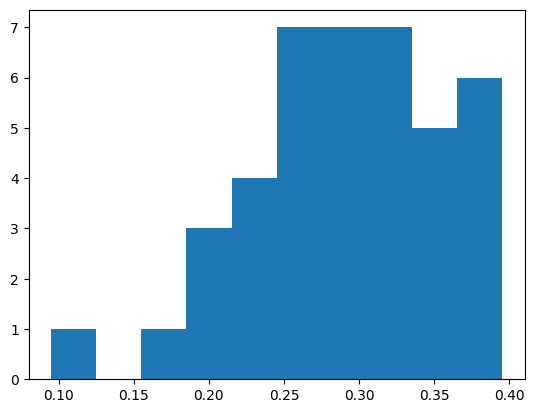

Processing search results for: - What are the core values that guide your team or organization?


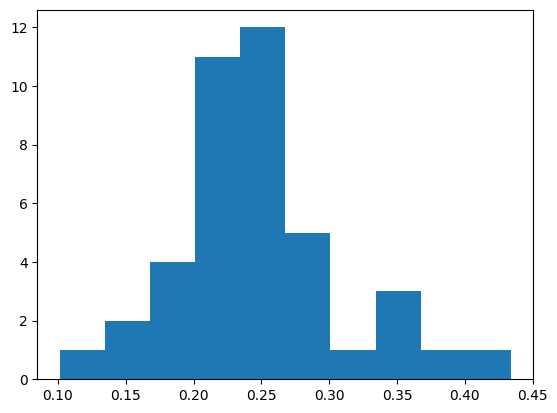

Processing search results for: - What is the current team dynamic or culture like, and what challenges do you face in inspiring your team?


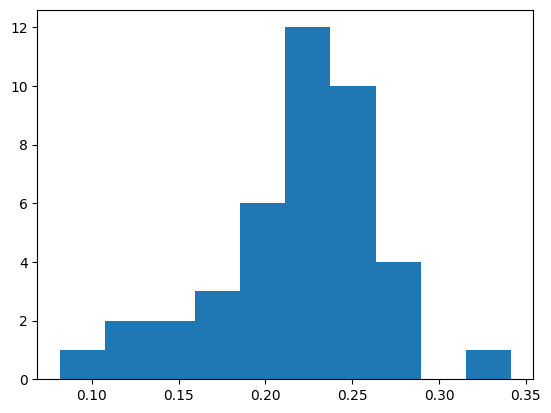

STATE PRINT {'question': 'How can I inspire my team toward achieving our long-term goals while maintaining alignment with our core values?', 'context': [Document(id='d3c31663-b96d-4ad5-8301-5a8ac2456ef9', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\who.json', 'seq_num': 1}, page_content=', "Continuous improvement", "Transparency in communication", "Integrity in decision-making", "Resilience in overcoming challenges"], "Personality Traits": ["Goal-oriented", "Systematic", "Resourceful"'), Document(id='9005eb9f-2985-4773-9472-f2b60cf1e802', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\who.json', 'seq_num': 1}, page_content='{"Name": "Charles River", "DOB": "1976", "Gender": "Male", "Core Values": ["Precision in execution", "Data-backed decisions", "Open, honest feedback", "Continuous improvement"')], 'desiredInformation': ['- What are the specific long-term goals your team is 

In [42]:
question = "How can I inspire my team toward achieving our long-term goals while maintaining alignment with our core values?"
answer = graph.invoke({"question": question})
print(answer)


In [153]:
graph2.invoke({"question": question})

researching  contains personal information about the user.
PROMPT:  You are preparing to answer the following question: Given your knowledge of where I'd like to go, and the plan we've agreed upon, what should I be doing on a daily basis?. You are given access to a json database that contains contains information about the user's plan to obtain each of their desires from a high level. with the following schema: {
subPlan: Array<{
    goal: {
        description: string,
        deadline: string  // ISO date format
    },
    justification: string,
    actionItems: Array<{
        what: string,
        when: string,    // Schedule description
        duration: string  // Time period
    }>
}>
}. Generate a list of newline-separated natural language queries that will help you answer the question. Questions should be detailed, specific, and useful.
QUERIES:  1. What are the specific goals outlined in your plan, including their descriptions and deadlines?
2. Can you provide the justificati

{'question': "Given your knowledge of where I'd like to go, and the plan we've agreed upon, what should I be doing on a daily basis?",
 'context': [Document(id='07d55754-ae3e-4f5a-888e-b1850c3db53f', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"description": "Build healthy habits for personal growth and stability", "deadline": "2025-06-01"'),
  Document(id='6ad69418-b1d8-4fcb-85f5-83afa92df118', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Develop a morning routine with exercise and mindfulness", "when": "Daily, 7:00 AM", "duration": "1 hour"},'),
  Document(id='bad485bb-f0bb-416c-a5e0-d24b509283d2', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Attend 2 networking events monthly", "when": "Second and fourth 

len raw_results 32


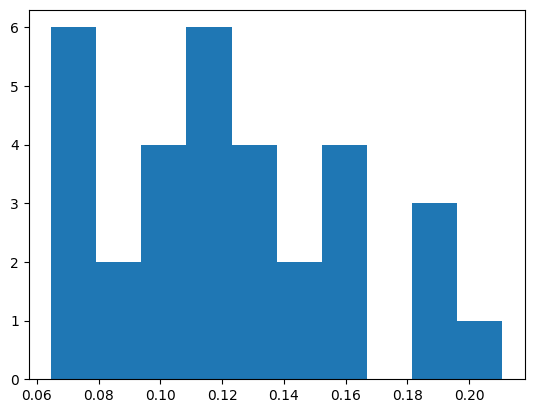

state['context'] [Document(id='a1157d38-7591-4ce0-8557-d9d16b52230d', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\who.json', 'seq_num': 1}, page_content='}')]


{'question': 'this has nothing to do with the project, curiousity killed the cat',
 'context': [Document(id='a1157d38-7591-4ce0-8557-d9d16b52230d', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\who.json', 'seq_num': 1}, page_content='}')],
 'answer': "I don't know."}

In [154]:
graph.invoke({"question": "this has nothing to do with the project, curiousity killed the cat"})

In [ ]:
graph.invoke({"question": "this has nothing to do with the project, curiousity killed the cat"})

len raw_results 32


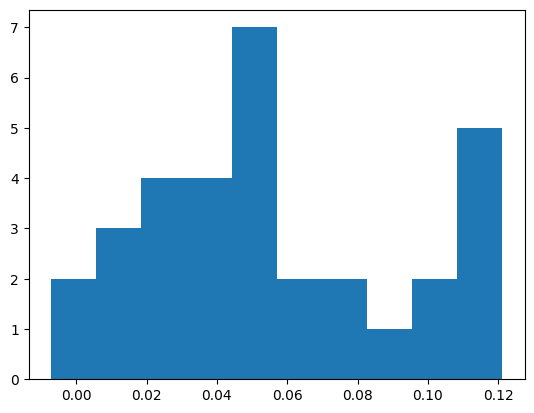

state['context'] [Document(id='4515ff90-ecdd-4696-ab93-6619f5f3a67e', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Attend social mixers or community events monthly", "when": "Last Friday of each month", "duration": "3 hours"},')]


{'question': 'A donkey and a parrot walked into a bar. What happens next?',
 'context': [Document(id='4515ff90-ecdd-4696-ab93-6619f5f3a67e', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Attend social mixers or community events monthly", "when": "Last Friday of each month", "duration": "3 hours"},')],
 'answer': "I don't know."}

In [104]:
graph.invoke({"question": "A donkey and a parrot walked into a bar. What happens next?"})

len raw_results 32


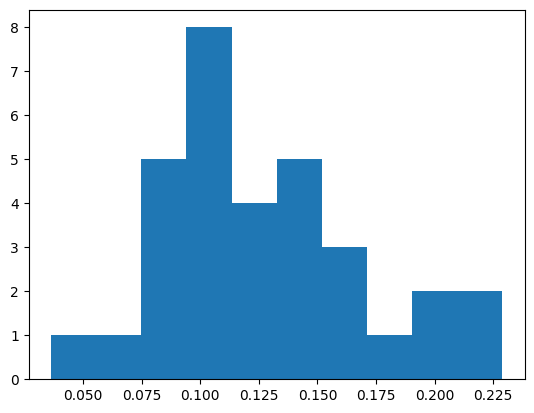

state['context'] [Document(id='acc427a8-28cc-40ec-85e2-299b748b906a', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "deadline": "2025-03-31"'), Document(id='385b64e2-ac81-4b88-8516-c9bf5a845324', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "strength": 10, "timeliness": "3 months"},')]


{'question': 'I am very interested in Arize AI. Tell me more about what they do.',
 'context': [Document(id='acc427a8-28cc-40ec-85e2-299b748b906a', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "deadline": "2025-03-31"'),
  Document(id='385b64e2-ac81-4b88-8516-c9bf5a845324', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "strength": 10, "timeliness": "3 months"},')],
 'answer': "I don't know."}

In [105]:
graph.invoke({"question": "I am very interested in Arize AI. Tell me more about what they do."})

len raw_results 32


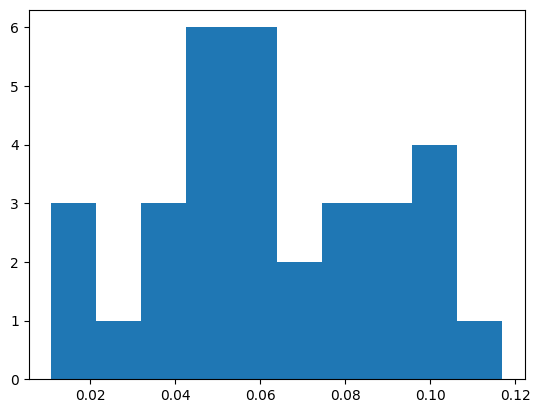

state['context'] [Document(id='4515ff90-ecdd-4696-ab93-6619f5f3a67e', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Attend social mixers or community events monthly", "when": "Last Friday of each month", "duration": "3 hours"},')]


{'question': 'my milkshake brings all the boys to the yard. What is a milkshake?',
 'context': [Document(id='4515ff90-ecdd-4696-ab93-6619f5f3a67e', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Attend social mixers or community events monthly", "when": "Last Friday of each month", "duration": "3 hours"},')],
 'answer': "I don't know."}

In [106]:
graph.invoke({"question": "my milkshake brings all the boys to the yard. What is a milkshake?"})